In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')

In [8]:
# import technology table
def return_technology():
    technology = pd.read_csv(f'./../data/technology.csv')
    return technology

In [9]:
# import fuel tax data
def return_fueltax():
    fuel_tax = pd.read_excel(f'./../TEAM-Kenya_data_out/base-case-kenya-data/FuelPrice-kenyavalues.xlsx')
    return fuel_tax

In [10]:
# import energy data
def return_energy_consumption(scenario):
    energy_consumption = pd.read_excel(f'./../scenarios/data-out/{scenario}/VEEMEIM_QF.xlsx')  
    return energy_consumption

In [11]:
years = range(2015, 2051)
scenarios = ['OMOKA', 'ELECTRICDREAMS', 'KUJINAO', 'STREETFIGHTING']

In [12]:
fuel_tax = return_fueltax()

taxation_by_scenario = {}

for scenario in scenarios:
    
    consumption = return_energy_consumption(scenario)
        
    fuel_taxation = {}
    for year in years:
        
        taxation_by_fuel = {}
        for fuelID in consumption.FuelID.unique():
            
            fuel_sold = consumption[(consumption['Year'] == year) & (consumption['FuelID'] == fuelID)]['VEEMQF_Value'].sum()*1e6  # litres or kWh
            
            tax_collected = fuel_tax[fuel_tax['FuelID'] == fuelID]['Duty'].item() * fuel_sold + (fuel_tax[fuel_tax['FuelID'] == fuelID]['ValueAddedTax'].item() - 1) * (fuel_tax[fuel_tax['FuelID'] == fuelID]['BasicCost'].item() + fuel_tax[fuel_tax['FuelID'] == fuelID]['Duty'].item()) * fuel_sold
            
            taxation_by_fuel[fuelID] = tax_collected * 150 * 1e-9 # GBP --> KES bn
            
        fuel_taxation[year] = taxation_by_fuel
            
    taxation_by_scenario[scenario] = fuel_taxation

In [13]:
chart_data = {}

for scenario in scenarios:
    
    series = []
    for year in years:
        series.append(sum(taxation_by_scenario[scenario][year].values()))
    
    chart_data[scenario] = series
    

In [14]:
chart_data_by_fuel = {}

for scenario in scenarios:
    data_by_fuel = {}
    
    consumption = return_energy_consumption(scenario)
    
    for fuelID in consumption.FuelID.unique():
        
        series = []
        for year in years:
            series.append(taxation_by_scenario[scenario][year][fuelID])
        
        data_by_fuel[fuelID] = series
        
    chart_data_by_fuel[scenario] = data_by_fuel

In [15]:
legend_labels = {'omoka':'Omoka', 'electricdreams': 'Electric Dreams', 'kujinao': 'Kujinao', 'streetfighting': 'Streetfighting'}

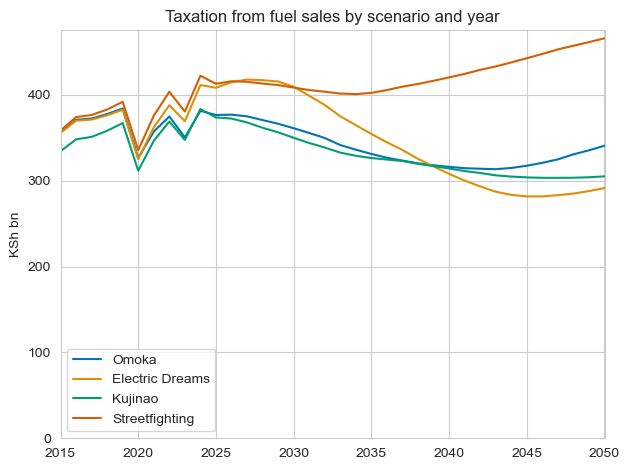

In [16]:
fig, ax = plt.subplots()
clrs = sns.color_palette('colorblind')

cnt = 0
for scenario in scenarios:
    ax.plot(range(2015, 2051), chart_data[scenario], color=clrs[cnt], label=legend_labels[scenario.lower()])
    
    cnt += 1
    
ax.legend()
ax.set_ylabel('KSh bn')
ax.set_ylim(bottom=0)
ax.set_xlim(left=2015, right=2050)
ax.set_title('Taxation from fuel sales by scenario and year')
fig.tight_layout()

plt.savefig('fuel-sales-tax.pdf')
plt.savefig('fuel-sales-tax.png')

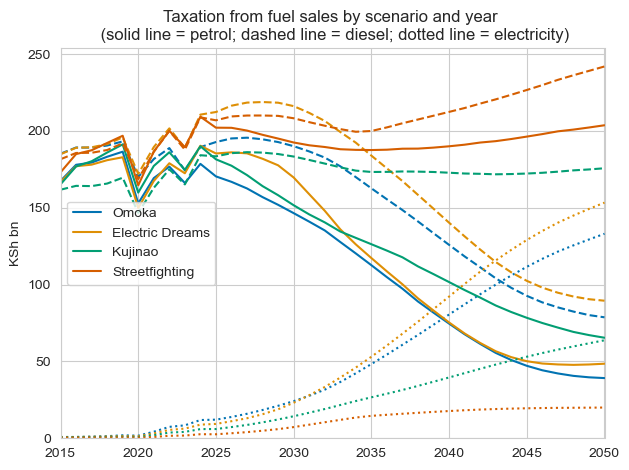

In [17]:
fig, ax = plt.subplots()
clrs = sns.color_palette('colorblind')

lnstls = ['-','--',':','.-']
cnt = 0
for scenario in scenarios:
    lnstl_cnt = 0
    
    for fuelID in [1, 2, 12]:
        if (lnstl_cnt == 0):
            ax.plot(range(2015, 2051), chart_data_by_fuel[scenario][fuelID], color=clrs[cnt], label=legend_labels[scenario.lower()], linestyle=lnstls[lnstl_cnt])
        else:
            ax.plot(range(2015, 2051), chart_data_by_fuel[scenario][fuelID], color=clrs[cnt], linestyle=lnstls[lnstl_cnt])
        
        lnstl_cnt += 1
    cnt += 1
    
ax.legend()
ax.set_ylabel('KSh bn')
ax.set_ylim(bottom=0)
ax.set_xlim(left=2015, right=2050)
ax.set_title('Taxation from fuel sales by scenario and year \n (solid line = petrol; dashed line = diesel; dotted line = electricity)')

fig.tight_layout()
plt.savefig('fuel-sales-tax-by-fuel.pdf')
plt.savefig('fuel-sales-tax-by-fuel.png')

In [18]:
for scenario in scenarios:
    print(chart_data[scenario][-1])

340.6752920782831
291.3880370172675
304.9427550059852
465.6852049237827


In [19]:
# export chart data to csv for report
# export chart data to csv for report
chart_df = pd.DataFrame(chart_data)
chart_df['Year'] = range(2015, 2051)
chart_df = chart_df[['Year']+[c for c in chart_df.columns if c != 'Year']]
chart_df.to_csv('./csv/fuel-taxation.csv', index=False)

In [20]:
fuel_lookup = {1:'Gasoline', 2:'Diesel', 12:'Electricity'}

chart_df_by_fuel = pd.DataFrame()

for scenario in scenarios:

    for fuelID in [1, 2, 12]:

            chart_df_by_fuel[f'{scenario} {fuel_lookup[fuelID]}'] = chart_data_by_fuel[scenario][fuelID]
            
chart_df_by_fuel['Year'] = range(2015, 2051)
chart_df_by_fuel = chart_df_by_fuel[['Year']+[c for c in chart_df_by_fuel.columns if c != 'Year']]
chart_df_by_fuel.to_csv('./csv/fuel-taxation-by-fuel.csv', index=False)